In [200]:
#importing packages
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import json
import json
import urllib.request, urllib.error, urllib.parse
import time

# 1

## a)

In [201]:
#reading in the csv files
panel = pd.read_csv('panel.csv')
yelp = pd.read_csv('yelp.csv')

In [202]:
#preprocessing the data/ initialzing the new columns
yelp['review_year'] = 0
yelp['review_int'] = 0
panel['yelp_count'] = 0
panel['yelp_average'] = 0.0
panel['yelp_NYC_count'] = 0
panel['yelp_NYC_average'] = 0.0

In [203]:
#converting review string to integer
for i in range(len(yelp['review_year'])):
    yelp['review_int'][i] = int(yelp['review_rating'][i][0])

In [204]:
#creating year column
for i in range(len(yelp['price'])):
    yelp['review_year'][i] = int(yelp['review_date'][i].split('-')[0])

In [205]:
#populating the yelp_count column
yelp_yr = yelp.groupby(['address_zipcode','review_year']).count().reset_index()
for i in range(len(panel)):
    panel['yelp_count'][i] = yelp_yr['NYC_reviewer'][i]

## b)

In [206]:
#populating the new yelp_average column
yelp_avg= yelp.groupby(['address_zipcode','review_year']).mean().reset_index() # grouping by zipcode and review and finding mean

#merging grouped dataframe with panel
for i in range(len(panel)):
    panel['yelp_average'][i] = yelp_avg['review_int'][i]

## c)

In [207]:
#populating the yelp_NYC_count column
yelpnyc = yelp[yelp['NYC_reviewer'] == 1.0]

yelpnyc_yr = yelpnyc.groupby(['address_zipcode','review_year']).count().reset_index()  #grouping by zipcode and review_year and finding count

#merging grouped dataframe with panel
xx = pd.merge(panel, yelpnyc_yr, left_on = ['zipcode','year'], right_on = ['address_zipcode', 'review_year'], how = 'outer')
xx= xx.fillna(0) #filling na values with zero

for i in range(len(panel)):
    panel['yelp_NYC_count'][i] = xx['review_int'][i]

## d)

In [208]:
#populating the yelp_NYC_average columns

yelpnyc_avg = yelpnyc.groupby(['address_zipcode','review_year']).mean().reset_index() #grouping the zipcode and review_year columns and finding mean

#merging the grouped data frame with panel
x2 = pd.merge(panel, yelpnyc_avg, left_on = ['zipcode','year'], right_on = ['address_zipcode', 'review_year'], how = 'outer')

#filling the missing values
x2 = x2.fillna(0)
for i in range(len(panel)):
    panel['yelp_NYC_average'][i] = x2['review_int'][i]

## e)

In [209]:
# writing to a csv file
panel.to_csv('panel_output.csv')

# 2)

## a)

<font color = 'purple'> **Reading-in the yelp file** </font>

In [210]:
yelp = pd.read_csv('yelp.csv')

<font color = 'purple'> **Importing important libraries** </font>

In [211]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import numpy as np
import statsmodels.api as sm
from scipy.stats import ttest_ind
warnings.filterwarnings("ignore")

<font color = 'purple'> **creating review_int and year column** </font>

In [212]:
yelp['review_int'] = 0.0
yelp['review_year'] = 0

#populating the columns
for i in range(len(yelp['price'])):
    yelp['review_int'][i] = yelp['review_rating'][i][0]
    
for i in range(len(yelp['price'])):
    yelp['review_year'][i] = int(yelp['review_date'][i].split('-')[0])

<font color = 'purple'> **Subsetting the data according to visitors and NewYork Citizens** </font>

In [213]:
visitor = yelp[yelp['NYC_reviewer']== 0.0]
visitor_avg = visitor.groupby(['address_zipcode','review_year']).mean().reset_index()

NYC_citizen = yelp[yelp['NYC_reviewer']== 1.0]
nyc_avg = NYC_citizen.groupby(['address_zipcode','review_year']).mean().reset_index()


<font color = 'purple'> **Visualizing the subsets** </font>

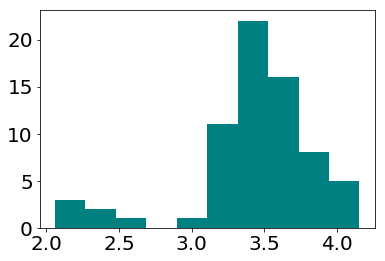

In [214]:
plt.hist(nyc_avg['review_int'], color = 'Teal')
plt.show()

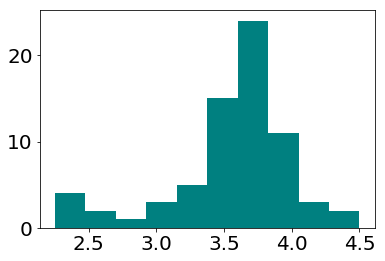

In [215]:
plt.hist(visitor_avg['review_int'], color = 'Teal')
plt.show()

<font color = 'purple'> **conducting T-test** </font>

<font color = 'purple'> Null Hypothesis = There is **no statistical** difference between average ratings by NewYork citizens and visitors</font>

<font color = 'purple'>Alternative Hypothesis = There is **statistical** difference between average ratings by NewYork citizens and visitors</font>

In [216]:
ttest_ind(nyc_avg['review_int'],visitor_avg['review_int'], equal_var=False )

Ttest_indResult(statistic=-1.7576036894795182, pvalue=0.08105308132964557)

<font color = 'red'>**From the above T-test we can clearly see that the p value is greater than 0.05 hence the difference is insignificant. Hence, we cannot reject Null Hypothesis**</font>

## b)

In [217]:
# removing the rows with price=Unclaimed restaurant
yelpp = yelp[yelp['price'] != 'UNCLAIMED RESTAURANT'].reset_index().drop('index', axis = 1)

#####  We have coded price as follows in our analysis:

<font color = 'purple'> $ = low </font> 

<font color = 'purple'> $$ = mid </font> 

<font color = 'purple'> $$$ = high </font> 

In [218]:
#coding the price variable with new values
yelpp['price'] = np.where(yelpp['price']=='$','low',
         np.where(yelpp['price']=='$$','mid',
          np.where(yelpp['price']=='$$$','high','luxury')))

<font color = 'purple'> **Creating Dummies for price and year**</font> 

In [219]:

dummy_price = pd.get_dummies(yelpp['price'], drop_first = True)

In [220]:
dummy_year = pd.get_dummies(yelpp['review_year'], drop_first = True)

In [221]:
yelpp = pd.concat([yelpp,dummy_price, dummy_year], axis = 1).drop(['review_rating','price','review_year','review_date','review_text'], axis = 1)

<font color = 'purple'> **Creating Interaction Terms**</font> 

In [222]:
for i in yelpp.columns[3:-1]:
    yelpp['NYC_reviewer*'+str(i)] = yelpp['NYC_reviewer'] * yelpp[i]

<font color = 'purple'> **Regression for Review Ratings**</font> 

In [223]:
Y = yelpp[yelpp.columns[2]]
X = yelpp.drop(['address_zipcode', 'review_int'], axis = 1)
X = sm.add_constant(X)

In [224]:
model = sm.OLS(Y, X.astype(float)).fit()
predictions = model.predict(X) 

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:             review_int   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     5.768
Date:                Sun, 08 Dec 2019   Prob (F-statistic):           4.86e-14
Time:                        23:40:45   Log-Likelihood:                -31735.
No. Observations:               18562   AIC:                         6.351e+04
Df Residuals:                   18543   BIC:                         6.366e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   3.8708    

<font color = 'red'> From the above model summary we can clearly see that the interaction term of reviewer, whether he is from NYC or a visitor, with different years is insignificant. Therefore for our further analysis we remove them</font> 

<font color = 'purple'> **Removing insignificant terms**</font> 

In [225]:
Y = yelpp[yelpp.columns[2]]
X = yelpp.drop(['address_zipcode','review_int','NYC_reviewer*2010','NYC_reviewer*2011',
            'NYC_reviewer*2012','NYC_reviewer*2013','NYC_reviewer*2014',2010,2011,2012,2013,2014,2015],axis=1)
X = sm.add_constant(X)

<font color = 'purple'> **Running the regression again**</font> 

In [226]:
model = sm.OLS(Y, X.astype(float)).fit()
predictions = model.predict(X) 

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:             review_int   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     12.58
Date:                Sun, 08 Dec 2019   Prob (F-statistic):           3.40e-16
Time:                        23:40:52   Log-Likelihood:                -31743.
No. Observations:               18562   AIC:                         6.350e+04
Df Residuals:                   18554   BIC:                         6.357e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   3.9079    

<font color = 'red'> From the above regression model, it is clear that there is no effect of rating when the resturant is luxury i.e. *SSSS* </font>

<font color = 'red'> Moreover, there is no effect of year on the rating. Meaning, the ratings don't differ by years  </font>

<font color = 'red'> Also, It is clear that a New York resident gives .13 less review rating than a visitor for low-priced *$* resturants. Same is the case with mid i.e. $$ resturant for which a nyc citizen gives .13 less rating than visitors </font>

<font color = 'red'> Generally, NYC reviewers give .39 less rating to the resturants </font> 

# 3

## a)

#### Reading-in the yelp csv file

In [227]:
yelp = pd.read_csv('yelp.csv')

#### Key phrase analysis using Azure


In [133]:
import requests
import time
azure_keyphrases = []
azure_sentiments = []

for tweets in yelp['review_text']:
    # Azure portal URL.
    base_url = 'https://westus.api.cognitive.microsoft.com/text/analytics/v2.0/'
    # The unique account key goes here.
    account_key = ''
        
    headers = {'Content-Type':'application/json', 'Ocp-Apim-Subscription-Key':account_key}

    documents = {"documents":[{"id":"1","text":tweets}]} 

    # Detect key phrases.
    batch_keyphrase_url = base_url + 'keyPhrases'
    headers   = {'Ocp-Apim-Subscription-Key': account_key}
    response  = requests.post(batch_keyphrase_url, headers=headers, json=documents)
    
    key_phrases = response.json()
    print(key_phrases)
    time.sleep(20)

    azure_keyphrases.append(key_phrases['documents'][0]['keyPhrases'])

{'documents': [{'id': '1', 'keyPhrases': ['nice sandwich', 'breakfast sandwich sausage bacon eggs ham', 'hungry man', 'arizona snacky cakes donuts', 'door', 'Classic Urban Deli', 'lot', 'orders', 'dudes', 'laundry']}], 'errors': []}
{'documents': [{'id': '1', 'keyPhrases': ['nice Spanish bakery', "Jin's", 'milk', 'block', 'weird vibe', 'deli', 'soda', 'sandwiches', 'finger']}], 'errors': []}


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\17653\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-133-a5866ed66cf5>", line 23, in <module>
    time.sleep(20)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\17653\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2033, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\17653\Anaconda3\lib\genericpath.py", line 19, in exists
    os.stat(path)
OSError: [WinError 123] The filename, directory name, or volume label syntax is incorrect: '<ipython-input-133-a5866ed66cf5>'

During handling of the above exception, a

KeyboardInterrupt: 

#### Pushing key phrases into a csv file

In [134]:
st = ''
kp =[]
#iterating through the keyphrases
for p in azure_keyphrases:
    for t in p:
        st = st + t +","
    st = st[:-1]
    kp.append(st) #appending keyphrases to a list
    st = ''

    
#writing to a csv file    
f = open('azure_1.csv','w')
for u in kp:
    f.write(u+'\n')
f.close()  

#### Reading-in the keyphrases csv file

In [228]:
text = pd.read_csv('azure.csv')

#### Subsetting the reviews into NYC reviews and Non-NYC reviews

In [229]:
text.fillna('%',inplace=True)

col = list(text.columns)

cols = col
text['combined'] = text[cols].apply(lambda row: '|'.join(row.values.astype(str)), axis=1) # each review's keyphrases separated by pipe

text = text[['combined']]

text['NYC'] = yelp['NYC_reviewer']

text_NYC = text[text['NYC']==1.0] #subsetting the NYC residents' reviews

text_NYC.reset_index(inplace=True)

text_no_NYC = text[text['NYC']==0] #subsetting the NYC visitors' reviews

text_no_NYC.reset_index(inplace=True)

reviews_NYC = list(text_NYC['combined'])

##### Importing the packages


In [230]:
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
import nltk
import string
from nltk.corpus import stopwords
stopwords_list = stopwords.words('english') + list(string.punctuation)

#### Processing the keyphrases for NYC residents

In [231]:
word_list = {}
# stopwords_list = stopwords_list+list(['place','food','service','waiter','staff','waitress','restaurant','friends','people',
#                  'order','time','minutes','dinner','table','menu','best','thing','hours','seconds','manager',
#                  'owner','tables','things''neighborhood','times','way','neighborhood','rating','review','stars',
#                 'friend','prices','atmosphere','year','years','money','server','home','meal','area','point','hour','price',
#                 'night','day','music','delivery','spot','places','things','reason','experience','fact','bill','customers',
#                 'great food','good food','flavor','week','street','boyfriend','place','great place','door','kitchen',
#                'portions','sauce','bartender','dishes','taste','water','husband','star','location','business','drinks',
#                 'cheese','harlem','brunch','lunch','harlem','decor','fries','mac','ambiance',
#                 'lunch','family','dessert','waffles','coffee','rice','nyc','coffee','sides','visit','chicken','bar',
#                 'washington heights','salad','person','problem','servers','orders','checks','check','lot','reviews',
#                 'phone','hostess','quality','favourite','hostess','inwood','plate','evening','tip','establishment',
#                 'customer service','tip', 'restaurans','life','home','long time','days','chance','line','mins','wait',
#             'half','dish','meat','work','waiters','favorite','city','breakfast','restaurants','restaurant','space',
#                 'entrees','love','fried chicken','burgers','attention','girl','guy','kind','try','wow',
#                 'party','trip','bite','yelp','corner','beer','new york','meals','drink','counter','pizza',
#                 'appetizer','appetizers','great service','months','heights','shrimp','burger','bacon',
#                 'sandwiches','sandiwich','bread','beans','good service','perfection','cash','afternoon','town','guys','wife','group','blocks',
#                 'block','house','seating','fish','steak','owners','options','eggs','salmon','entree','room','world'])

#iterating through the keyphrases 
for i in range(0,len(reviews_NYC)):
    print(i)
    reviews_NYC[i] = reviews_NYC[i].lower() # converting to lowercase
    k = reviews_NYC[i].split('|') # splitting each keyphrase using the previously assigned delimiter |
    for t in range(0,len(k)):
        if k[t] in stopwords_list: # checking if the phrase is in stopwords
            continue
        if (k[t]=='%'): # breaks when % is encountered; defined % as the end of the keyphrases for each review
            break
        if k[t] in word_list:  # stores frequency count of each word in a dictionary
            word_list[k[t]] = word_list[k[t]] + 1
        else:
            word_list[k[t]] = 1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085
2086
2087
2088
2089
2090
2091
2092
2093
2094
2095
2096
2097
2098
2099
2100
2101
2102
2103
2104
2105
2106
2107
2108
2109
2110
2111
2112
2113
2114
2115
2116
2117
2118
2119
2120
2121
2122
2123
2124
2125
2126
2127
2128
2129
2130
2131
2132
2133
2134
2135
2136
2137
2138
2139
2140
2141
2142
2143
2144
2145
2146
2147
2148
2149
2150
2151
2152
2153
2154
2155
2156
2157
2158
2159
2160
2161
2162
2163
2164
2165
2166
2167
2168
2169
2170
2171
2172
2173
2174
2175
2176
2177
2178
2179
2180
2181
2182
2183
2184
2185
2186
2187
2188
2189
2190
2191
2192
2193
2194
2195
2196
2197
2198
2199
2200
2201
2202
2203
2204


3876
3877
3878
3879
3880
3881
3882
3883
3884
3885
3886
3887
3888
3889
3890
3891
3892
3893
3894
3895
3896
3897
3898
3899
3900
3901
3902
3903
3904
3905
3906
3907
3908
3909
3910
3911
3912
3913
3914
3915
3916
3917
3918
3919
3920
3921
3922
3923
3924
3925
3926
3927
3928
3929
3930
3931
3932
3933
3934
3935
3936
3937
3938
3939
3940
3941
3942
3943
3944
3945
3946
3947
3948
3949
3950
3951
3952
3953
3954
3955
3956
3957
3958
3959
3960
3961
3962
3963
3964
3965
3966
3967
3968
3969
3970
3971
3972
3973
3974
3975
3976
3977
3978
3979
3980
3981
3982
3983
3984
3985
3986
3987
3988
3989
3990
3991
3992
3993
3994
3995
3996
3997
3998
3999
4000
4001
4002
4003
4004
4005
4006
4007
4008
4009
4010
4011
4012
4013
4014
4015
4016
4017
4018
4019
4020
4021
4022
4023
4024
4025
4026
4027
4028
4029
4030
4031
4032
4033
4034
4035
4036
4037
4038
4039
4040
4041
4042
4043
4044
4045
4046
4047
4048
4049
4050
4051
4052
4053
4054
4055
4056
4057
4058
4059
4060
4061
4062
4063
4064
4065
4066
4067
4068
4069
4070
4071
4072
4073
4074
4075


5721
5722
5723
5724
5725
5726
5727
5728
5729
5730
5731
5732
5733
5734
5735
5736
5737
5738
5739
5740
5741
5742
5743
5744
5745
5746
5747
5748
5749
5750
5751
5752
5753
5754
5755
5756
5757
5758
5759
5760
5761
5762
5763
5764
5765
5766
5767
5768
5769
5770
5771
5772
5773
5774
5775
5776
5777
5778
5779
5780
5781
5782
5783
5784
5785
5786
5787
5788
5789
5790
5791
5792
5793
5794
5795
5796
5797
5798
5799
5800
5801
5802
5803
5804
5805
5806
5807
5808
5809
5810
5811
5812
5813
5814
5815
5816
5817
5818
5819
5820
5821
5822
5823
5824
5825
5826
5827
5828
5829
5830
5831
5832
5833
5834
5835
5836
5837
5838
5839
5840
5841
5842
5843
5844
5845
5846
5847
5848
5849
5850
5851
5852
5853
5854
5855
5856
5857
5858
5859
5860
5861
5862
5863
5864
5865
5866
5867
5868
5869
5870
5871
5872
5873
5874
5875
5876
5877
5878
5879
5880
5881
5882
5883
5884
5885
5886
5887
5888
5889
5890
5891
5892
5893
5894
5895
5896
5897
5898
5899
5900
5901
5902
5903
5904
5905
5906
5907
5908
5909
5910
5911
5912
5913
5914
5915
5916
5917
5918
5919
5920


7681
7682
7683
7684
7685
7686
7687
7688
7689
7690
7691
7692
7693
7694
7695
7696
7697
7698
7699
7700
7701
7702
7703
7704
7705
7706
7707
7708
7709
7710
7711
7712
7713
7714
7715
7716
7717
7718
7719
7720
7721
7722
7723
7724
7725
7726
7727
7728
7729
7730
7731
7732
7733
7734
7735
7736
7737
7738
7739
7740
7741
7742
7743
7744
7745
7746
7747
7748
7749
7750
7751
7752
7753
7754
7755
7756
7757
7758
7759
7760
7761
7762
7763
7764
7765
7766
7767
7768
7769
7770
7771
7772
7773
7774
7775
7776
7777
7778
7779
7780
7781
7782
7783
7784
7785
7786
7787
7788
7789
7790
7791
7792
7793
7794
7795
7796
7797
7798
7799
7800
7801
7802
7803
7804
7805
7806
7807
7808
7809
7810
7811
7812
7813
7814
7815
7816
7817
7818
7819
7820
7821
7822
7823
7824
7825
7826
7827
7828
7829
7830
7831
7832
7833
7834
7835
7836
7837
7838
7839
7840
7841
7842
7843
7844
7845
7846
7847
7848
7849
7850
7851
7852
7853
7854
7855
7856
7857
7858
7859
7860
7861
7862
7863
7864
7865
7866
7867
7868
7869
7870
7871
7872
7873
7874
7875
7876
7877
7878
7879
7880


9441
9442
9443
9444
9445
9446
9447
9448
9449
9450
9451
9452
9453
9454
9455
9456
9457
9458
9459
9460
9461
9462
9463
9464
9465
9466
9467
9468
9469
9470
9471
9472
9473
9474
9475
9476
9477
9478
9479
9480
9481
9482
9483
9484
9485
9486
9487
9488
9489
9490
9491
9492
9493
9494
9495
9496
9497
9498
9499
9500
9501
9502
9503
9504
9505
9506
9507
9508
9509
9510
9511
9512
9513
9514
9515
9516
9517
9518
9519
9520
9521
9522
9523
9524
9525
9526
9527
9528
9529
9530
9531
9532
9533
9534
9535
9536
9537
9538
9539
9540
9541
9542
9543
9544
9545
9546
9547
9548
9549
9550
9551
9552
9553
9554
9555
9556
9557
9558
9559
9560
9561
9562
9563
9564
9565
9566
9567
9568
9569
9570
9571
9572
9573
9574
9575
9576
9577
9578
9579
9580
9581
9582
9583
9584
9585
9586
9587
9588
9589
9590
9591
9592
9593
9594
9595
9596
9597
9598
9599
9600
9601
9602
9603
9604
9605
9606
9607
9608
9609
9610
9611
9612
9613
9614
9615
9616
9617
9618
9619
9620
9621
9622
9623
9624
9625
9626
9627
9628
9629
9630
9631
9632
9633
9634
9635


#### Visualizing the raw high frequency words for NYC residents

Text(0, 0.5, 'Frequency')

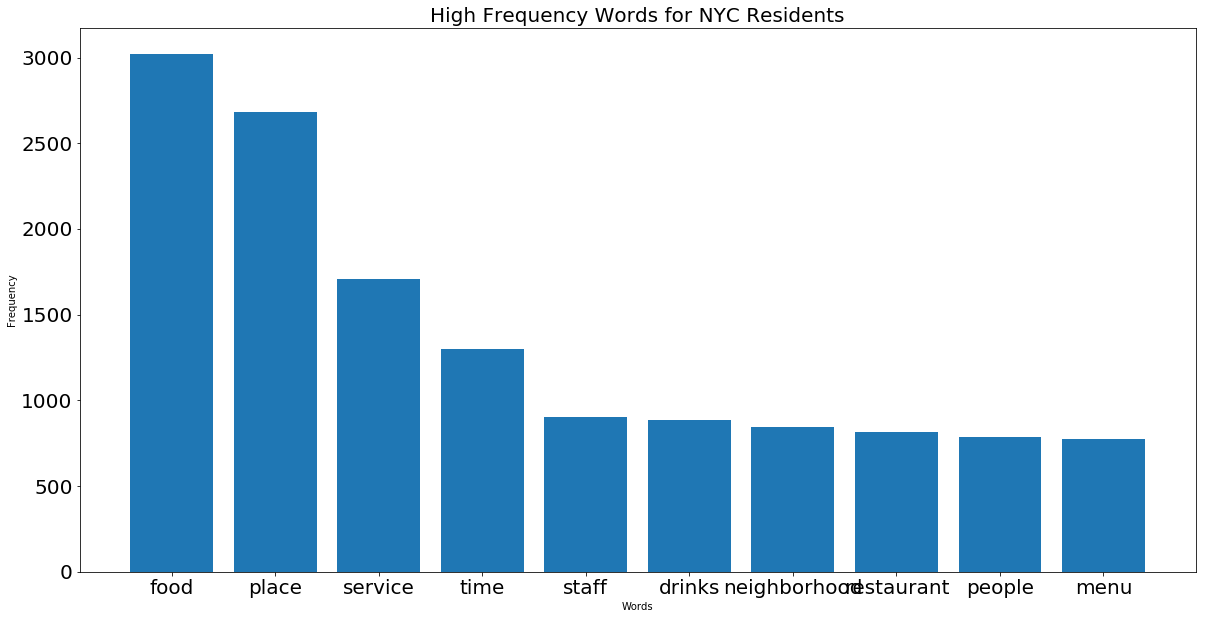

In [232]:
#sorting the dictionary
all = list(sorted(word_list.items(), key=lambda x: x[1], reverse=True))

#filtering the top ten words
all_NYC = all[:10]

#unpacking the tuples in the list
word = []
freq = []
for t in all_NYC:
    j,k = t
    word.append(j)
    freq.append(k)

#plotting the frequency count    
plt.figure(figsize=(20,10))
plt.bar(word,freq)
plt.title('High Frequency Words for NYC Residents',size=20)
plt.xlabel('Words')
plt.ylabel('Frequency')

#### Processing the keyphrases for the Non-NYC residents

In [233]:
reviews_no_NYC = list(text_no_NYC['combined'])
word_list_2 = {}
# stopwords_list = stopwords_list+list(['place','food','service','waiter','staff','waitress','restaurant','friends','people',
#                  'order','time','minutes','dinner','table','menu','best','thing','hours','seconds','manager',
#                  'owner','tables','things''neighborhood','times','way','neighborhood','rating','review','stars',
#                 'friend','prices','atmosphere','year','years','money','server','home','meal','area','point','hour','price',
#                 'night','day','music','delivery','spot','places','things','reason','experience','fact','bill','customers',
#                 'great food','good food','flavor','week','street','boyfriend','place','great place','door','kitchen',
#                'portions','sauce','bartender','dishes','taste','water','husband','star','location','business','drinks',
#                 'cheese','harlem','brunch','lunch','harlem','decor','fries','mac','ambiance',
#                 'lunch','family','dessert','waffles','coffee','rice','nyc','coffee','sides','visit','chicken','bar',
#                 'washington heights','salad','person','problem','servers','orders','checks','check','lot','reviews',
#                 'phone','hostess','quality','favourite','hostess','inwood','plate','evening','tip','establishment',
#                 'customer service','tip', 'restaurans','life','home','long time','days','chance','line','mins','wait',
#             'half','dish','meat','work','waiters','favorite','city','breakfast','restaurants','restaurant','space',
#                 'entrees','love','fried chicken','burgers','attention','girl','guy','kind','try','wow',
#                 'party','trip','bite','yelp','corner','beer','new york','meals','drink','counter','pizza',
#                 'appetizer','appetizers','great service','months','heights','shrimp','burger','bacon',
#                 'sandwiches','sandiwich','bread','beans','good service','perfection','cash','afternoon','town','guys','wife','group','blocks',
#                 'block','house','seating','fish','steak','owners','options','eggs','salmon','entree','room','world'])

#iterating through the keyphrases
for i in range(0,len(reviews_no_NYC)):
    print(i)
    reviews_no_NYC[i] = reviews_no_NYC[i].lower() # converting to lowercase
    k = reviews_no_NYC[i].split('|') # splitting each keyphrase using the previously assigned delimiter |
    for t in range(0,len(k)):
        if k[t] in stopwords_list: # checking if the phrase is in stopwords
            continue
        if (k[t]=='%'):  # breaks when % is encountered; defined % as the end of the keyphrases for each review
            break
        if k[t] in word_list_2: # stores frequency count of each word in a dictionary
            word_list_2[k[t]] = word_list_2[k[t]] + 1
        else:
            word_list_2[k[t]] = 1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

2457
2458
2459
2460
2461
2462
2463
2464
2465
2466
2467
2468
2469
2470
2471
2472
2473
2474
2475
2476
2477
2478
2479
2480
2481
2482
2483
2484
2485
2486
2487
2488
2489
2490
2491
2492
2493
2494
2495
2496
2497
2498
2499
2500
2501
2502
2503
2504
2505
2506
2507
2508
2509
2510
2511
2512
2513
2514
2515
2516
2517
2518
2519
2520
2521
2522
2523
2524
2525
2526
2527
2528
2529
2530
2531
2532
2533
2534
2535
2536
2537
2538
2539
2540
2541
2542
2543
2544
2545
2546
2547
2548
2549
2550
2551
2552
2553
2554
2555
2556
2557
2558
2559
2560
2561
2562
2563
2564
2565
2566
2567
2568
2569
2570
2571
2572
2573
2574
2575
2576
2577
2578
2579
2580
2581
2582
2583
2584
2585
2586
2587
2588
2589
2590
2591
2592
2593
2594
2595
2596
2597
2598
2599
2600
2601
2602
2603
2604
2605
2606
2607
2608
2609
2610
2611
2612
2613
2614
2615
2616
2617
2618
2619
2620
2621
2622
2623
2624
2625
2626
2627
2628
2629
2630
2631
2632
2633
2634
2635
2636
2637
2638
2639
2640
2641
2642
2643
2644
2645
2646
2647
2648
2649
2650
2651
2652
2653
2654
2655
2656


4108
4109
4110
4111
4112
4113
4114
4115
4116
4117
4118
4119
4120
4121
4122
4123
4124
4125
4126
4127
4128
4129
4130
4131
4132
4133
4134
4135
4136
4137
4138
4139
4140
4141
4142
4143
4144
4145
4146
4147
4148
4149
4150
4151
4152
4153
4154
4155
4156
4157
4158
4159
4160
4161
4162
4163
4164
4165
4166
4167
4168
4169
4170
4171
4172
4173
4174
4175
4176
4177
4178
4179
4180
4181
4182
4183
4184
4185
4186
4187
4188
4189
4190
4191
4192
4193
4194
4195
4196
4197
4198
4199
4200
4201
4202
4203
4204
4205
4206
4207
4208
4209
4210
4211
4212
4213
4214
4215
4216
4217
4218
4219
4220
4221
4222
4223
4224
4225
4226
4227
4228
4229
4230
4231
4232
4233
4234
4235
4236
4237
4238
4239
4240
4241
4242
4243
4244
4245
4246
4247
4248
4249
4250
4251
4252
4253
4254
4255
4256
4257
4258
4259
4260
4261
4262
4263
4264
4265
4266
4267
4268
4269
4270
4271
4272
4273
4274
4275
4276
4277
4278
4279
4280
4281
4282
4283
4284
4285
4286
4287
4288
4289
4290
4291
4292
4293
4294
4295
4296
4297
4298
4299
4300
4301
4302
4303
4304
4305
4306
4307


5767
5768
5769
5770
5771
5772
5773
5774
5775
5776
5777
5778
5779
5780
5781
5782
5783
5784
5785
5786
5787
5788
5789
5790
5791
5792
5793
5794
5795
5796
5797
5798
5799
5800
5801
5802
5803
5804
5805
5806
5807
5808
5809
5810
5811
5812
5813
5814
5815
5816
5817
5818
5819
5820
5821
5822
5823
5824
5825
5826
5827
5828
5829
5830
5831
5832
5833
5834
5835
5836
5837
5838
5839
5840
5841
5842
5843
5844
5845
5846
5847
5848
5849
5850
5851
5852
5853
5854
5855
5856
5857
5858
5859
5860
5861
5862
5863
5864
5865
5866
5867
5868
5869
5870
5871
5872
5873
5874
5875
5876
5877
5878
5879
5880
5881
5882
5883
5884
5885
5886
5887
5888
5889
5890
5891
5892
5893
5894
5895
5896
5897
5898
5899
5900
5901
5902
5903
5904
5905
5906
5907
5908
5909
5910
5911
5912
5913
5914
5915
5916
5917
5918
5919
5920
5921
5922
5923
5924
5925
5926
5927
5928
5929
5930
5931
5932
5933
5934
5935
5936
5937
5938
5939
5940
5941
5942
5943
5944
5945
5946
5947
5948
5949
5950
5951
5952
5953
5954
5955
5956
5957
5958
5959
5960
5961
5962
5963
5964
5965
5966


7419
7420
7421
7422
7423
7424
7425
7426
7427
7428
7429
7430
7431
7432
7433
7434
7435
7436
7437
7438
7439
7440
7441
7442
7443
7444
7445
7446
7447
7448
7449
7450
7451
7452
7453
7454
7455
7456
7457
7458
7459
7460
7461
7462
7463
7464
7465
7466
7467
7468
7469
7470
7471
7472
7473
7474
7475
7476
7477
7478
7479
7480
7481
7482
7483
7484
7485
7486
7487
7488
7489
7490
7491
7492
7493
7494
7495
7496
7497
7498
7499
7500
7501
7502
7503
7504
7505
7506
7507
7508
7509
7510
7511
7512
7513
7514
7515
7516
7517
7518
7519
7520
7521
7522
7523
7524
7525
7526
7527
7528
7529
7530
7531
7532
7533
7534
7535
7536
7537
7538
7539
7540
7541
7542
7543
7544
7545
7546
7547
7548
7549
7550
7551
7552
7553
7554
7555
7556
7557
7558
7559
7560
7561
7562
7563
7564
7565
7566
7567
7568
7569
7570
7571
7572
7573
7574
7575
7576
7577
7578
7579
7580
7581
7582
7583
7584
7585
7586
7587
7588
7589
7590
7591
7592
7593
7594
7595
7596
7597
7598
7599
7600
7601
7602
7603
7604
7605
7606
7607
7608
7609
7610
7611
7612
7613
7614
7615
7616
7617
7618


#### Visualizing the raw high-frequency words for Non-NYC residents

Text(0, 0.5, 'Frequency')

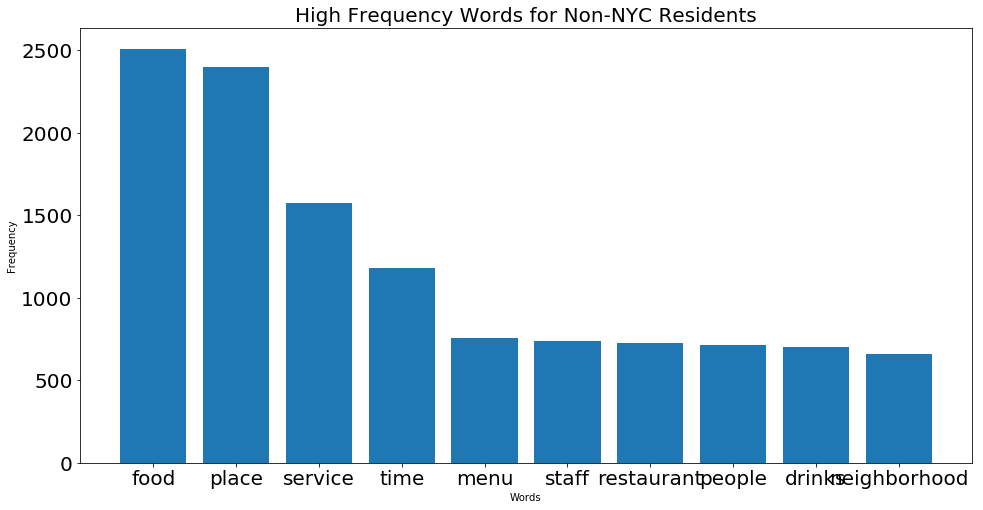

In [234]:
#sorting the dictionary
all_2 = list(sorted(word_list_2.items(), key=lambda x: x[1], reverse=True))

#filtering the top ten words
all_no_NYC = all_2[:10]

#unpacking the tuples in the list
word_2 = []
freq_2 = []
for t in all_no_NYC:
    j,k = t
    word_2.append(j)
    freq_2.append(k)

  #plotting the frequency count  
plt.figure(figsize=(16,8))
plt.bar(word_2,freq_2)
plt.title('High Frequency Words for Non-NYC Residents',size=20)
plt.xlabel('Words')
plt.ylabel('Frequency')

### Since the high-frequency words are almost the same for both NYC residents and NYC visitors, we use a different approach

#### Finding the high-frequency words that are specifically used by NYC residents and NYC visitors

In [235]:
#calculating the percentage difference in frequency for the top 1000 frequently occuring words in both sets of keyphrases

stop = {}
for i in all[:1000]:
    w,f = i
    for j in all_2[:1000]:
        wo,fr = j
        if (w==wo) & ((f >100)|(fr>100)):  # calculating the percentage and seeing if it crosses the 100 count threshold
            stop[w] = (f-fr)/f * 100
            break

#storing the unique words            
stop = list(sorted(stop.items(), key=lambda x: x[1], reverse=True))


#filtering the unique words for nyc residents and non-nyc residents
non_nyc = stop[-8:-1]
nyc = stop[0:6]

#packing the words for residents 
word_list={}
for g in nyc:
    i,j = g
    word_list[i]=0

#packing the words for residents    
word_list_2={}
for g in non_nyc:
    i,j = g
    word_list_2[i]=0
    


#### Getting the frequency count for all those specific words

In [236]:
# getting the frequency count for the unique words to NYC residents
for i in range(0,len(reviews_NYC)):
    print(i)
    reviews_NYC[i] = reviews_NYC[i].lower()
    k = reviews_NYC[i].split('|')
    for t in range(0,len(k)):
        if k[t] in stopwords_list:
            continue
        if (k[t]=='%'):
            break
        if k[t] in word_list:
            word_list[k[t]] = word_list[k[t]] + 1

            
# getting the frequency count for the unique words to NYC visitors
for i in range(0,len(reviews_no_NYC)):
    print(i)
    reviews_no_NYC[i] = reviews_no_NYC[i].lower()
    k = reviews_no_NYC[i].split('|')
    for t in range(0,len(k)):
        if k[t] in stopwords_list:
            continue
        if (k[t]=='%'):
            break
        if k[t] in word_list_2:
            word_list_2[k[t]] = word_list_2[k[t]] + 1       

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

2113
2114
2115
2116
2117
2118
2119
2120
2121
2122
2123
2124
2125
2126
2127
2128
2129
2130
2131
2132
2133
2134
2135
2136
2137
2138
2139
2140
2141
2142
2143
2144
2145
2146
2147
2148
2149
2150
2151
2152
2153
2154
2155
2156
2157
2158
2159
2160
2161
2162
2163
2164
2165
2166
2167
2168
2169
2170
2171
2172
2173
2174
2175
2176
2177
2178
2179
2180
2181
2182
2183
2184
2185
2186
2187
2188
2189
2190
2191
2192
2193
2194
2195
2196
2197
2198
2199
2200
2201
2202
2203
2204
2205
2206
2207
2208
2209
2210
2211
2212
2213
2214
2215
2216
2217
2218
2219
2220
2221
2222
2223
2224
2225
2226
2227
2228
2229
2230
2231
2232
2233
2234
2235
2236
2237
2238
2239
2240
2241
2242
2243
2244
2245
2246
2247
2248
2249
2250
2251
2252
2253
2254
2255
2256
2257
2258
2259
2260
2261
2262
2263
2264
2265
2266
2267
2268
2269
2270
2271
2272
2273
2274
2275
2276
2277
2278
2279
2280
2281
2282
2283
2284
2285
2286
2287
2288
2289
2290
2291
2292
2293
2294
2295
2296
2297
2298
2299
2300
2301
2302
2303
2304
2305
2306
2307
2308
2309
2310
2311
2312


3861
3862
3863
3864
3865
3866
3867
3868
3869
3870
3871
3872
3873
3874
3875
3876
3877
3878
3879
3880
3881
3882
3883
3884
3885
3886
3887
3888
3889
3890
3891
3892
3893
3894
3895
3896
3897
3898
3899
3900
3901
3902
3903
3904
3905
3906
3907
3908
3909
3910
3911
3912
3913
3914
3915
3916
3917
3918
3919
3920
3921
3922
3923
3924
3925
3926
3927
3928
3929
3930
3931
3932
3933
3934
3935
3936
3937
3938
3939
3940
3941
3942
3943
3944
3945
3946
3947
3948
3949
3950
3951
3952
3953
3954
3955
3956
3957
3958
3959
3960
3961
3962
3963
3964
3965
3966
3967
3968
3969
3970
3971
3972
3973
3974
3975
3976
3977
3978
3979
3980
3981
3982
3983
3984
3985
3986
3987
3988
3989
3990
3991
3992
3993
3994
3995
3996
3997
3998
3999
4000
4001
4002
4003
4004
4005
4006
4007
4008
4009
4010
4011
4012
4013
4014
4015
4016
4017
4018
4019
4020
4021
4022
4023
4024
4025
4026
4027
4028
4029
4030
4031
4032
4033
4034
4035
4036
4037
4038
4039
4040
4041
4042
4043
4044
4045
4046
4047
4048
4049
4050
4051
4052
4053
4054
4055
4056
4057
4058
4059
4060


5860
5861
5862
5863
5864
5865
5866
5867
5868
5869
5870
5871
5872
5873
5874
5875
5876
5877
5878
5879
5880
5881
5882
5883
5884
5885
5886
5887
5888
5889
5890
5891
5892
5893
5894
5895
5896
5897
5898
5899
5900
5901
5902
5903
5904
5905
5906
5907
5908
5909
5910
5911
5912
5913
5914
5915
5916
5917
5918
5919
5920
5921
5922
5923
5924
5925
5926
5927
5928
5929
5930
5931
5932
5933
5934
5935
5936
5937
5938
5939
5940
5941
5942
5943
5944
5945
5946
5947
5948
5949
5950
5951
5952
5953
5954
5955
5956
5957
5958
5959
5960
5961
5962
5963
5964
5965
5966
5967
5968
5969
5970
5971
5972
5973
5974
5975
5976
5977
5978
5979
5980
5981
5982
5983
5984
5985
5986
5987
5988
5989
5990
5991
5992
5993
5994
5995
5996
5997
5998
5999
6000
6001
6002
6003
6004
6005
6006
6007
6008
6009
6010
6011
6012
6013
6014
6015
6016
6017
6018
6019
6020
6021
6022
6023
6024
6025
6026
6027
6028
6029
6030
6031
6032
6033
6034
6035
6036
6037
6038
6039
6040
6041
6042
6043
6044
6045
6046
6047
6048
6049
6050
6051
6052
6053
6054
6055
6056
6057
6058
6059


7634
7635
7636
7637
7638
7639
7640
7641
7642
7643
7644
7645
7646
7647
7648
7649
7650
7651
7652
7653
7654
7655
7656
7657
7658
7659
7660
7661
7662
7663
7664
7665
7666
7667
7668
7669
7670
7671
7672
7673
7674
7675
7676
7677
7678
7679
7680
7681
7682
7683
7684
7685
7686
7687
7688
7689
7690
7691
7692
7693
7694
7695
7696
7697
7698
7699
7700
7701
7702
7703
7704
7705
7706
7707
7708
7709
7710
7711
7712
7713
7714
7715
7716
7717
7718
7719
7720
7721
7722
7723
7724
7725
7726
7727
7728
7729
7730
7731
7732
7733
7734
7735
7736
7737
7738
7739
7740
7741
7742
7743
7744
7745
7746
7747
7748
7749
7750
7751
7752
7753
7754
7755
7756
7757
7758
7759
7760
7761
7762
7763
7764
7765
7766
7767
7768
7769
7770
7771
7772
7773
7774
7775
7776
7777
7778
7779
7780
7781
7782
7783
7784
7785
7786
7787
7788
7789
7790
7791
7792
7793
7794
7795
7796
7797
7798
7799
7800
7801
7802
7803
7804
7805
7806
7807
7808
7809
7810
7811
7812
7813
7814
7815
7816
7817
7818
7819
7820
7821
7822
7823
7824
7825
7826
7827
7828
7829
7830
7831
7832
7833


9563
9564
9565
9566
9567
9568
9569
9570
9571
9572
9573
9574
9575
9576
9577
9578
9579
9580
9581
9582
9583
9584
9585
9586
9587
9588
9589
9590
9591
9592
9593
9594
9595
9596
9597
9598
9599
9600
9601
9602
9603
9604
9605
9606
9607
9608
9609
9610
9611
9612
9613
9614
9615
9616
9617
9618
9619
9620
9621
9622
9623
9624
9625
9626
9627
9628
9629
9630
9631
9632
9633
9634
9635
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
1

2499
2500
2501
2502
2503
2504
2505
2506
2507
2508
2509
2510
2511
2512
2513
2514
2515
2516
2517
2518
2519
2520
2521
2522
2523
2524
2525
2526
2527
2528
2529
2530
2531
2532
2533
2534
2535
2536
2537
2538
2539
2540
2541
2542
2543
2544
2545
2546
2547
2548
2549
2550
2551
2552
2553
2554
2555
2556
2557
2558
2559
2560
2561
2562
2563
2564
2565
2566
2567
2568
2569
2570
2571
2572
2573
2574
2575
2576
2577
2578
2579
2580
2581
2582
2583
2584
2585
2586
2587
2588
2589
2590
2591
2592
2593
2594
2595
2596
2597
2598
2599
2600
2601
2602
2603
2604
2605
2606
2607
2608
2609
2610
2611
2612
2613
2614
2615
2616
2617
2618
2619
2620
2621
2622
2623
2624
2625
2626
2627
2628
2629
2630
2631
2632
2633
2634
2635
2636
2637
2638
2639
2640
2641
2642
2643
2644
2645
2646
2647
2648
2649
2650
2651
2652
2653
2654
2655
2656
2657
2658
2659
2660
2661
2662
2663
2664
2665
2666
2667
2668
2669
2670
2671
2672
2673
2674
2675
2676
2677
2678
2679
2680
2681
2682
2683
2684
2685
2686
2687
2688
2689
2690
2691
2692
2693
2694
2695
2696
2697
2698


4569
4570
4571
4572
4573
4574
4575
4576
4577
4578
4579
4580
4581
4582
4583
4584
4585
4586
4587
4588
4589
4590
4591
4592
4593
4594
4595
4596
4597
4598
4599
4600
4601
4602
4603
4604
4605
4606
4607
4608
4609
4610
4611
4612
4613
4614
4615
4616
4617
4618
4619
4620
4621
4622
4623
4624
4625
4626
4627
4628
4629
4630
4631
4632
4633
4634
4635
4636
4637
4638
4639
4640
4641
4642
4643
4644
4645
4646
4647
4648
4649
4650
4651
4652
4653
4654
4655
4656
4657
4658
4659
4660
4661
4662
4663
4664
4665
4666
4667
4668
4669
4670
4671
4672
4673
4674
4675
4676
4677
4678
4679
4680
4681
4682
4683
4684
4685
4686
4687
4688
4689
4690
4691
4692
4693
4694
4695
4696
4697
4698
4699
4700
4701
4702
4703
4704
4705
4706
4707
4708
4709
4710
4711
4712
4713
4714
4715
4716
4717
4718
4719
4720
4721
4722
4723
4724
4725
4726
4727
4728
4729
4730
4731
4732
4733
4734
4735
4736
4737
4738
4739
4740
4741
4742
4743
4744
4745
4746
4747
4748
4749
4750
4751
4752
4753
4754
4755
4756
4757
4758
4759
4760
4761
4762
4763
4764
4765
4766
4767
4768


6496
6497
6498
6499
6500
6501
6502
6503
6504
6505
6506
6507
6508
6509
6510
6511
6512
6513
6514
6515
6516
6517
6518
6519
6520
6521
6522
6523
6524
6525
6526
6527
6528
6529
6530
6531
6532
6533
6534
6535
6536
6537
6538
6539
6540
6541
6542
6543
6544
6545
6546
6547
6548
6549
6550
6551
6552
6553
6554
6555
6556
6557
6558
6559
6560
6561
6562
6563
6564
6565
6566
6567
6568
6569
6570
6571
6572
6573
6574
6575
6576
6577
6578
6579
6580
6581
6582
6583
6584
6585
6586
6587
6588
6589
6590
6591
6592
6593
6594
6595
6596
6597
6598
6599
6600
6601
6602
6603
6604
6605
6606
6607
6608
6609
6610
6611
6612
6613
6614
6615
6616
6617
6618
6619
6620
6621
6622
6623
6624
6625
6626
6627
6628
6629
6630
6631
6632
6633
6634
6635
6636
6637
6638
6639
6640
6641
6642
6643
6644
6645
6646
6647
6648
6649
6650
6651
6652
6653
6654
6655
6656
6657
6658
6659
6660
6661
6662
6663
6664
6665
6666
6667
6668
6669
6670
6671
6672
6673
6674
6675
6676
6677
6678
6679
6680
6681
6682
6683
6684
6685
6686
6687
6688
6689
6690
6691
6692
6693
6694
6695


8419
8420
8421
8422
8423
8424
8425
8426
8427
8428
8429
8430
8431
8432
8433
8434
8435
8436
8437
8438
8439
8440
8441
8442
8443
8444
8445
8446
8447
8448
8449
8450
8451
8452
8453
8454
8455
8456
8457
8458
8459
8460
8461
8462
8463
8464
8465
8466
8467
8468
8469
8470
8471
8472
8473
8474
8475
8476
8477
8478
8479
8480
8481
8482
8483
8484
8485
8486
8487
8488
8489
8490
8491
8492
8493
8494
8495
8496
8497
8498
8499
8500
8501
8502
8503
8504
8505
8506
8507
8508
8509
8510
8511
8512
8513
8514
8515
8516
8517
8518
8519
8520
8521
8522
8523
8524
8525
8526
8527
8528
8529
8530
8531
8532
8533
8534
8535
8536
8537
8538
8539
8540
8541
8542
8543
8544
8545
8546
8547
8548
8549
8550
8551
8552
8553
8554
8555
8556
8557
8558
8559
8560
8561
8562
8563
8564
8565
8566
8567
8568
8569
8570
8571
8572
8573
8574
8575
8576
8577
8578
8579
8580
8581
8582
8583
8584
8585
8586
8587
8588
8589
8590
8591
8592
8593
8594
8595
8596
8597
8598
8599
8600
8601
8602
8603
8604
8605
8606
8607
8608
8609
8610
8611
8612
8613
8614
8615
8616
8617
8618


#### Visualizing the unique words to NYC residents

Text(0, 0.5, 'Frequency')

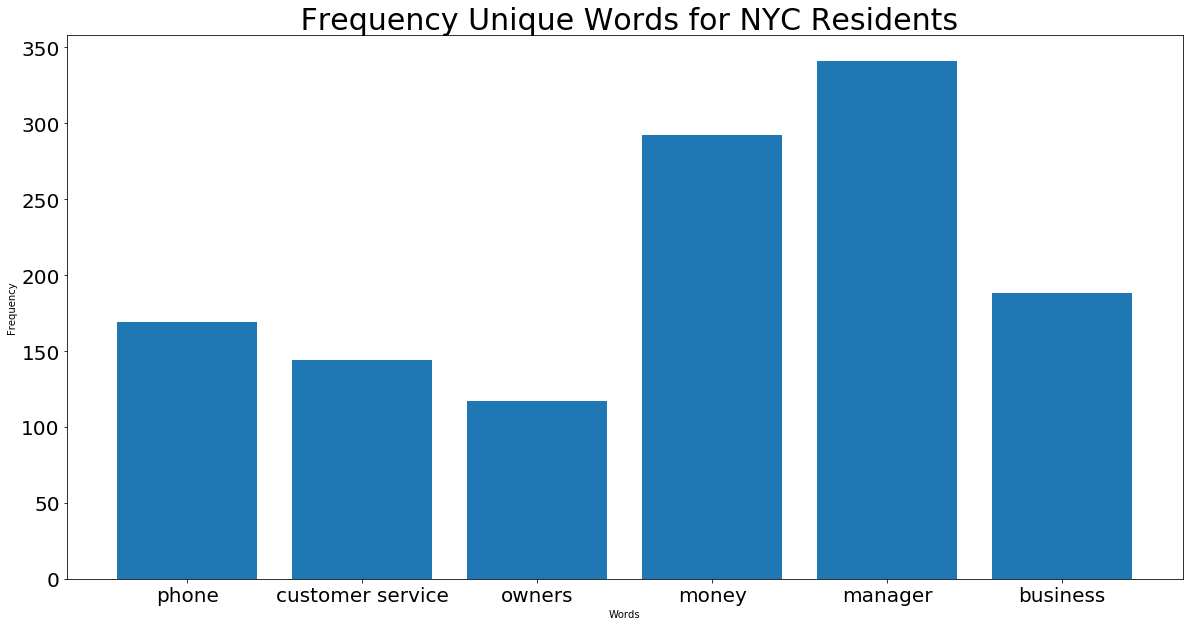

In [237]:
#plotting the unique words to NYC residents
plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)
plt.figure(figsize=(20,10))
plt.bar(word_list.keys(),word_list.values())
plt.title(' Frequency Unique Words for NYC Residents',size=30)
plt.xlabel('Words')
plt.ylabel('Frequency')


#### Visualizing the unique words to NYC visitors

Text(0, 0.5, 'Frequency')

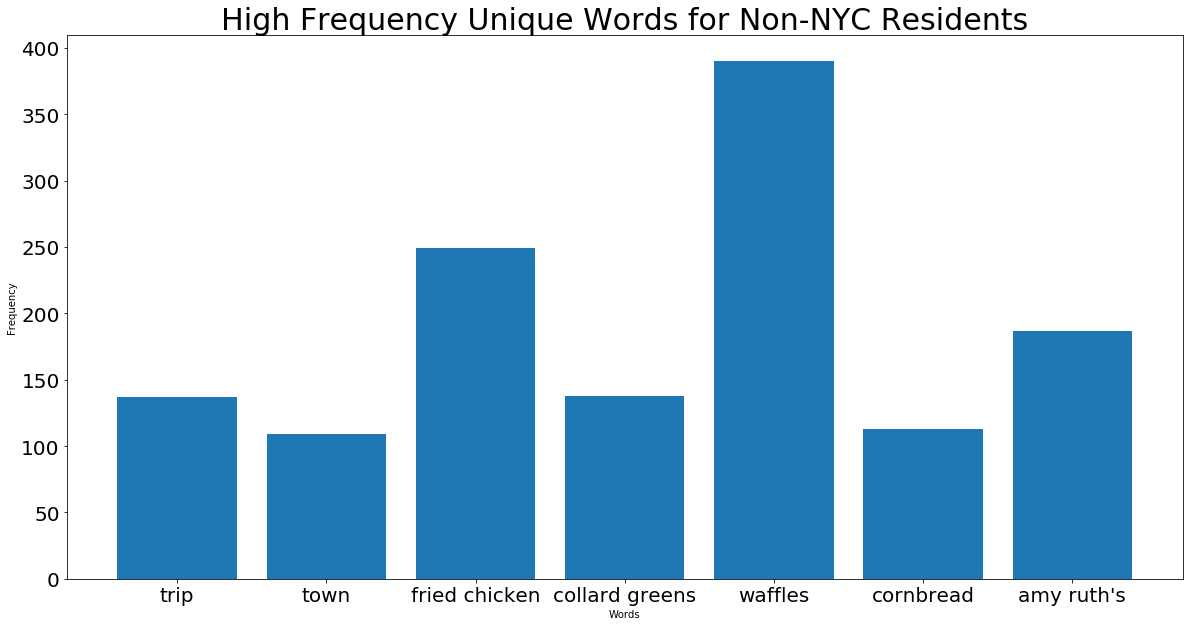

In [238]:
#plotting the unique words to NYC visitors
plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)
plt.figure(figsize=(20,10))
plt.bar(word_list_2.keys(),word_list_2.values())
plt.title('High Frequency Unique Words for Non-NYC Residents',size=30)
plt.xlabel('Words')
plt.ylabel('Frequency')


#### Approach:
#### Since our initial approach of identifying the high-frequency words for NYC residents and NYC visitors did not yield any significant insights, we had to think of a unique way of identifying the words that are specifically used more by NYC visitors than NYC residents, and vice versa. We were able to achieve this by checking the percentage difference between the frequency of words that appeared in NYC residents' reviews and NYC visitors' reviews.

#### Percentage Difference: The difference in the frequencies of word divided by the bigger frequency amongst the two frequencies (NYC resident and NYC visitor). This would give us the words that are used most by one and not so much by the other.

#### Example:

#### NYC Resident = {'mimosa : 40}
#### NYC visitor = {'mimosa: 15}

####  Frequency of word mimosa for NYC resident: 40
#### Frequency of word mimosa for NYC visitor: 15

#### Percentage Difference: ((40-15)/40) *100


#### The words with the highest percentage difference were the unique high frequency words for that party - NYC resident and NYC visitor

# 4

## a)

#### Reading-in the csv file

In [239]:
df = pd.read_csv('panel_output.csv')

#### Calculating the distance from each zipcode to 5 popular destinations in NYC: Central Park, Statue of Liberty, Metropolitan Museum of Art, Broadway and The Theater District, and the Empire State Building

In [240]:
import json
import json
import urllib.request, urllib.error, urllib.parse
import time

### Please provide your key here
yourKey = ''
import urllib.request, urllib.error, urllib.parse
import json

#getting the list of unique zipcodes
l = []
for i in df['zipcode'].unique():
   l.append(i)

# converting to integers
for i in range(len(l)):
    l[i] = str(l[i]).split('.')[0]
    l[i] = int(l[i])

#initializing the destination list    
dest = ['central+park','statue+of+liberty','metropolitan+museum+of+art','broadway+and+the+theater+district',
        'empire+state+building']

#initializing a separate list for each destination that will have the distance to the zipcodes
des = {}
for k in dest:
    des[k] = []

#getting the distance to the popular destinations from each zipcode    
for i in l:
    for j in dest:
        print(str(i))
        results_unstructured = urllib.request.urlopen('https://maps.googleapis.com/maps/api/distancematrix/json?origins='+str(i)+'&destinations='+j+'&units=imperial&key='+yourKey).read()
        results = json.loads(results_unstructured)
        des[j].append(results['rows'][0]['elements'][0]['distance']['text'].split(' ')[0])


10026
10026
10026
10026
10026
10031
10031
10031
10031
10031
10032
10032
10032
10032
10032
10033
10033
10033
10033
10033
10034
10034
10034
10034
10034
10466
10466
10466
10466
10466
10468
10468
10468
10468
10468
10475
10475
10475
10475
10475
11234
11234
11234
11234
11234
11432
11432
11432
11432
11432


#### Storing the results in a dataframe 

In [241]:
fin = pd.DataFrame({'zipcode':l,'central_park':des['central+park'],
                    'statue_of_liberty':des['statue+of+liberty'],
                    'metropolitan_museum_of_art':des['metropolitan+museum+of+art'],
                    'broadway_and_the_theater_district':des['broadway+and+the+theater+district'],
                   'empire_state_building':des['empire+state+building']})

# converting the distance string to numeric dtype
fin['central_park'] = pd.to_numeric(fin['central_park'])
fin['statue_of_liberty'] = pd.to_numeric(fin['statue_of_liberty'])
fin['metropolitan_museum_of_art'] = pd.to_numeric(fin['metropolitan_museum_of_art'])
fin['broadway_and_the_theater_district'] = pd.to_numeric(fin['broadway_and_the_theater_district'])
fin['empire_state_building'] = pd.to_numeric(fin['empire_state_building'])




#### Calculating the mean distance to the five destinations for each zipcode 

In [242]:
fin['mean_distance'] = fin[['central_park', 'statue_of_liberty','metropolitan_museum_of_art', 'broadway_and_the_theater_district','empire_state_building']].mean(axis=1)

#### Preprocessing the data for visualization

In [243]:
panel['zipcode'].astype(str).str.split('.',expand=True)[0]

0     10026
1     10026
2     10026
3     10026
4     10026
      ...  
65    11432
66    11432
67    11432
68    11432
69    11432
Name: 0, Length: 70, dtype: object

In [244]:
fin['zipcode'] = fin['zipcode'].astype(str)

panel['zipcode'] = panel['zipcode'].astype(str).str.split('.',expand=True)[0]

panel = pd.merge(panel,fin[['zipcode','mean_distance']],on='zipcode')

panel_1 = panel[['zipcode','airbnb']].groupby(['zipcode']).mean().reset_index()

fin = pd.merge(fin,panel_1, on='zipcode')

fin.sort_values('mean_distance', inplace=True)

fin['airbnb'] = fin['airbnb'] *100

### Visualizing the percentage of demand for each zipcode

#### Percentage of Demand:

#### Zipcode: 10031

##### Year 2009:0
##### Year 2010:0
##### Year 2011:0
##### Year 2012:0
##### Year 2013:1
##### Year 2014:1
##### Year 2015:1

##### Percentage of Demand: (1+1+1)/ (No. of years) * 100 = 3 / 7 * 100 =  42.8 percent

Text(0, 0.5, 'Percent of Demand')

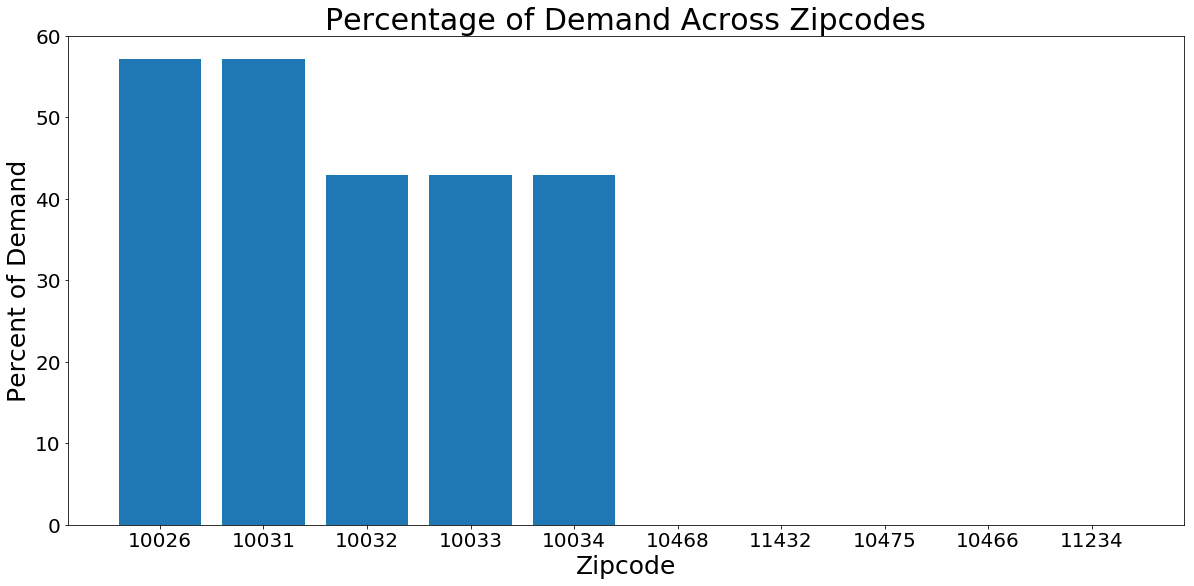

In [245]:
#plotting the demand percentage for each zipcode
X = list(fin.iloc[:4,0])
Y = list(fin.iloc[:4,7])


X = list(fin.iloc[:,0])
Y = list(fin.iloc[:,7])
plt.figure(figsize=(20,9))

plt.bar(X,Y)
plt.title('Percentage of Demand Across Zipcodes',size=30)
plt.xlabel('Zipcode',size=25)
plt.ylabel('Percent of Demand',size=25)
# plt.rc('xtick',labelsize=20)
# plt.rc('ytick',labelsize=20)

### Visualizing the median distance to popular destinations for each zipcode

#### Zipcode: 10031

#### Distance to Destination_1: 2 miles

#### Distance to Destination_1: 4 miles

#### Distance to Destination_1: 5 miles

#### Distance to Destination_1: 6 miles

#### Distance to Destination_1: 9 miles

#### Mean Distance: 5.2 miles





Text(0, 0.5, 'Mean Distance in Miles')

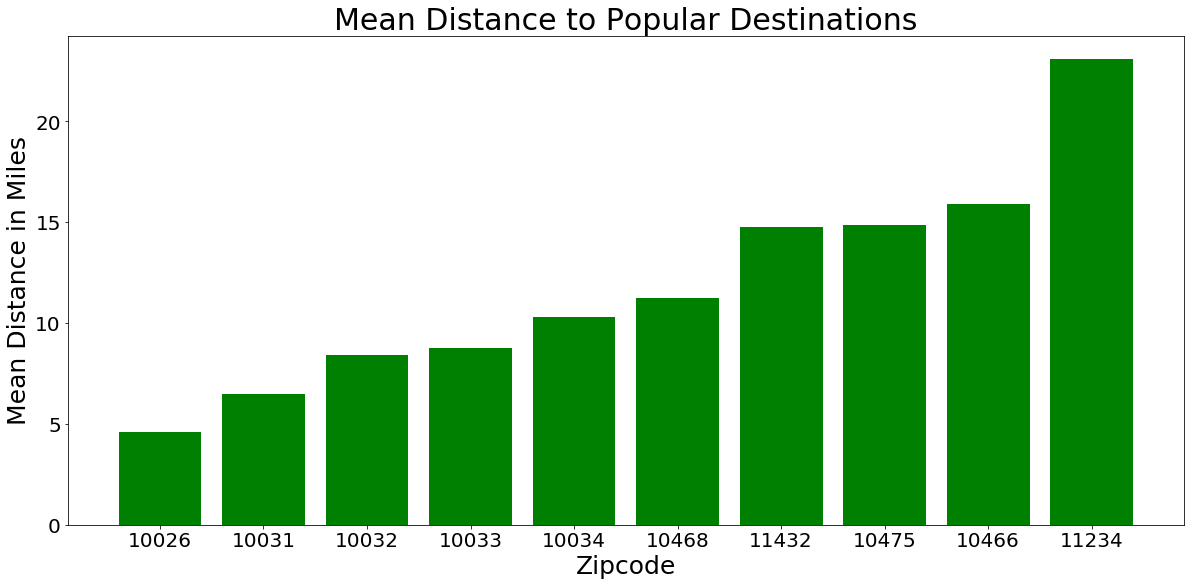

In [246]:
#plotting the mean distance
X=list(fin.iloc[:,0])
Y=list(fin.iloc[:,6])
plt.figure(figsize=(20,9))
plt.bar(X,Y,color="green")
plt.title('Mean Distance to Popular Destinations',size=30)
plt.xlabel('Zipcode',size=25)
plt.ylabel('Mean Distance in Miles',size=25)
# plt.rc('xtick',labelsize=20)
# plt.rc('ytick',labelsize=20)

## Conclusion:
#### As evident from the above two graphs, the demand is high for zipcodes which have the least mean distance to the popular destinations. This implies that zipcodes located near popular destinations have higher demand than zipcodes that are far away from popular destinations.

###  Zipcodes:
#### 10026, 10030, 10031, 10032, 10033, 10034 have the highest demand with the least mean distance to the five popular destinations.

### Rationale for Using Mean Distance: 
#### Mean Distance is good measure for estimating the centrality of a location in a city. 





## b)

#### Reading the Airbnb_NYC_2019 dataset sourced from Kaggle

In [247]:
data = pd.read_csv('AB_NYC_2019.csv')

#### Preprocessing the data

In [248]:
data.dropna(inplace=True)

#### Getting the Top 150 neighbourhoods in terms of number of reviews

In [249]:
#grouping the neighbourhoods according to decreasing order of number of reviews and then filtering the top 150 neighbourhoods
top_neigh = list(data[['neighbourhood','number_of_reviews']].groupby('neighbourhood').sum().sort_values(by='number_of_reviews',ascending=False).reset_index()['neighbourhood'])[0:150]

top = top_neigh.copy()

#cleaning the neighbourhoods strings
for i in range(0,len(top_neigh)):
    top_neigh[i] = top_neigh[i].replace(' ','+')
    top_neigh[i] = top_neigh[i].replace("'",'')
    top_neigh[i] = top_neigh[i].replace(',','')
    top_neigh[i] = top_neigh[i]+',NY'


#### Calculating the distance of each of these neighbourhoods with five popular destinations: Empire State Building, Rockefeller Center, Times Square, Statue of Liberty, and Central Park

In [ ]:
#fetching the distance to from each zipcode to destination
yourKey = ''

dest = ['central+park','statue+of+liberty','times+square','rockefeller+center',
        'empire+state+building']

des = {}
for k in dest:
    des[k] = []

for i in top_neigh:
    for j in dest:
        print(str(i))
        results_unstructured = urllib.request.urlopen('https://maps.googleapis.com/maps/api/distancematrix/json?origins='+str(i)+'&destinations='+j+'&units=imperial&key='+yourKey).read()
        results = json.loads(results_unstructured)
        des[j].append(results['rows'][0]['elements'][0]['distance']['text'].split(' ')[0])

Bedford-Stuyvesant,NY
Bedford-Stuyvesant,NY
Bedford-Stuyvesant,NY
Bedford-Stuyvesant,NY
Bedford-Stuyvesant,NY
Williamsburg,NY
Williamsburg,NY
Williamsburg,NY
Williamsburg,NY
Williamsburg,NY
Harlem,NY
Harlem,NY
Harlem,NY
Harlem,NY
Harlem,NY
Bushwick,NY
Bushwick,NY
Bushwick,NY
Bushwick,NY
Bushwick,NY
Hells+Kitchen,NY
Hells+Kitchen,NY
Hells+Kitchen,NY
Hells+Kitchen,NY
Hells+Kitchen,NY
East+Village,NY
East+Village,NY
East+Village,NY
East+Village,NY
East+Village,NY
East+Harlem,NY
East+Harlem,NY
East+Harlem,NY
East+Harlem,NY
East+Harlem,NY
Crown+Heights,NY
Crown+Heights,NY
Crown+Heights,NY
Crown+Heights,NY
Crown+Heights,NY
Upper+West+Side,NY
Upper+West+Side,NY
Upper+West+Side,NY
Upper+West+Side,NY
Upper+West+Side,NY
Upper+East+Side,NY
Upper+East+Side,NY
Upper+East+Side,NY
Upper+East+Side,NY
Upper+East+Side,NY
Lower+East+Side,NY
Lower+East+Side,NY
Lower+East+Side,NY
Lower+East+Side,NY
Lower+East+Side,NY
Chelsea,NY
Chelsea,NY
Chelsea,NY
Chelsea,NY
Chelsea,NY
Midtown,NY
Midtown,NY
Midtown,NY
Mi

Parkchester,NY
Parkchester,NY
Parkchester,NY
Parkchester,NY
Parkchester,NY
Concourse+Village,NY
Concourse+Village,NY
Concourse+Village,NY
Concourse+Village,NY
Concourse+Village,NY
University+Heights,NY
University+Heights,NY
University+Heights,NY
University+Heights,NY
University+Heights,NY
Throgs+Neck,NY
Throgs+Neck,NY
Throgs+Neck,NY
Throgs+Neck,NY
Throgs+Neck,NY
City+Island,NY
City+Island,NY
City+Island,NY
City+Island,NY
City+Island,NY
Fort+Hamilton,NY
Fort+Hamilton,NY
Fort+Hamilton,NY
Fort+Hamilton,NY
Fort+Hamilton,NY
Clifton,NY
Clifton,NY
Clifton,NY
Clifton,NY
Clifton,NY
Columbia+St,NY
Columbia+St,NY
Columbia+St,NY
Columbia+St,NY
Columbia+St,NY
West+Brighton,NY
West+Brighton,NY
West+Brighton,NY
West+Brighton,NY
West+Brighton,NY
Concord,NY
Concord,NY
Concord,NY
Concord,NY
Concord,NY
Civic+Center,NY
Civic+Center,NY
Civic+Center,NY
Civic+Center,NY
Civic+Center,NY
Jamaica+Estates,NY
Jamaica+Estates,NY
Jamaica+Estates,NY
Jamaica+Estates,NY
Jamaica+Estates,NY
Battery+Park+City,NY
Battery+P

#### Storing the results in a dataframe

In [174]:
fin_3 = pd.DataFrame({'neighbourhood':top_neigh,'central_park':des['central+park'],
                    'statue_of_liberty':des['statue+of+liberty'],
                    'times_square':des['times+square'],
                    'rockefeller_center':des['rockefeller+center'],
                   'empire_state_building':des['empire+state+building']})

#converting distance to numeric dtype
fin_3['central_park'] = pd.to_numeric(fin_3['central_park'])
fin_3['statue_of_liberty'] = pd.to_numeric(fin_3['statue_of_liberty'])
fin_3['times_square'] = pd.to_numeric(fin_3['times_square'])
fin_3['rockefeller_center'] = pd.to_numeric(fin_3['rockefeller_center'])
fin_3['empire_state_building'] = pd.to_numeric(fin_3['empire_state_building'])


#### Preprocessing the data before modelling

In [175]:
fin_3['Sum'] = fin_3.mean(axis=1)

fin_3['No_of_reviews']  = data[['neighbourhood','number_of_reviews']].groupby('neighbourhood').sum().sort_values(by='number_of_reviews',ascending=False).reset_index()['number_of_reviews'][0:150]

fin_3['price'] = data[['neighbourhood','price']].groupby('neighbourhood').mean().sort_values(by='price',ascending=False).reset_index()['price'][0:150]

fin_3.rename(columns = {'Sum':'Centrality'},inplace=True)


#natural log on variables that have skewed distributions
fin_3['log(No_of_reviews)'] = np.log(fin_3['No_of_reviews'])

fin_3['log(Centrality)'] = np.log(fin_3['Centrality'] )

fin_3['log(price)'] = np.log(fin_3['price'])

fin_3.drop(['No_of_reviews','Centrality','price'],axis=1,inplace=True)

#### Writing to a csv file

In [176]:
fin_3.to_csv('Model_Q4_b.csv')

#### Reading in the file

In [177]:
fin_3 = pd.read_csv('Model_Q4_b.csv')
fin_3.drop('Unnamed: 0',axis=1, inplace=True)

#### Checking for correlation between mean distance to 5 popular destinations for each neighbourhood and number of reviews

In [178]:
#Correlation between centrality distance and no_of_reviews
fin_3['log(Centrality)'].corr(fin_3['log(No_of_reviews)'])

-0.4531270653159664

#### Visualizing the relationship between mean distance and number of reviews

Text(0, 0.5, 'Centrality_Distance')

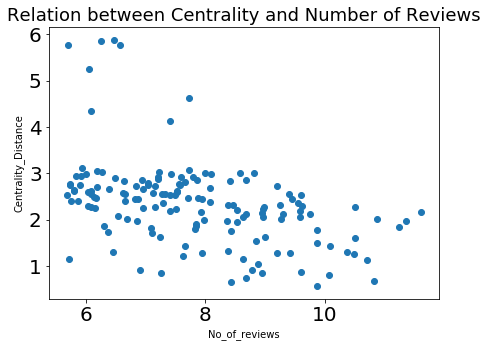

In [179]:
#plotting the relationship between mean distance and number of reviews
plt.figure(figsize=(7,5))
plt.scatter(fin_3['log(No_of_reviews)'],fin_3['log(Centrality)'])
plt.title('Relation between Centrality and Number of Reviews',size=18)
plt.xlabel('No_of_reviews')
plt.ylabel('Centrality_Distance')


#### Building a Linear Regression Model with Avg Price in Neighbourhood and Mean Distance as independent variables and Number of Reviews as dependent variable

In [180]:
import statsmodels.api as sm

model = sm.OLS(fin_3['log(No_of_reviews)'],fin_3[['log(Centrality)','log(price)']])

results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:     log(No_of_reviews)   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     9602.
Date:                Sun, 08 Dec 2019   Prob (F-statistic):          2.42e-157
Time:                        23:30:02   Log-Likelihood:                -158.11
No. Observations:                 150   AIC:                             320.2
Df Residuals:                     148   BIC:                             326.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
log(Centrality)    -0.4886      0.056     

## Conclusion

### Approach:
#### - Downloaded a static dataset from Kaggle that has Airbnb listings for the year 2019: The link: https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data

####  - Grouped the dataset according to neighbourhoods and then sorted them based on the descending order of number of reviews. Following which, the top 150 rows were filtered for the purpose of modelling and better evaluating the relationship between distance to popular destinations and demand.

####  - The distance to five popular destinations : Empire State Building, Rockefeller Center, Times Square, Statue of Liberty, and Central Park were calculated for each of these neighbourhoods


####  - Just like in part A, we used the mean distance as the centrality measure for each neighbourhood

####  - Visualized the relationship between mean distance and number of reviews for these neighbourhoods

####  - Checked the correlation between mean distance and number of reviews

####  - Built a linear regression model with avg price of listing in neighbourhood and mean distance



### Results

#### - There is negative correlation between mean distance to popular destinations from each neighbourhood and number of reviews. The correlation coefficient is -0.45.

#### - The scatterplot between mean distance and the number of reviews shows the negative correlation

#### - The linear regression model shows that with 1 percent increase in mean distance there is a 0.48 percent decrease in the number of reviews, when price is zero. These results are consistent with out previous findings in Q4, part A.
